#For dataset download

In [1]:
import torch
print(torch.version.cuda)          # Should show 12.6
print(torch.cuda.is_available())   # Should return True

12.6
True


In [2]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:33<00:00, 185MB/s]
100% 5.20G/5.20G [00:33<00:00, 168MB/s]


In [4]:
!unzip skin-cancer-mnist-ham10000.zip -d ham10000

Streaming output truncated to the last 5000 lines.
  inflating: ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_002

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


C:\Users\prosh\AppData\Local\Temp\ipykernel_19336\792317508.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


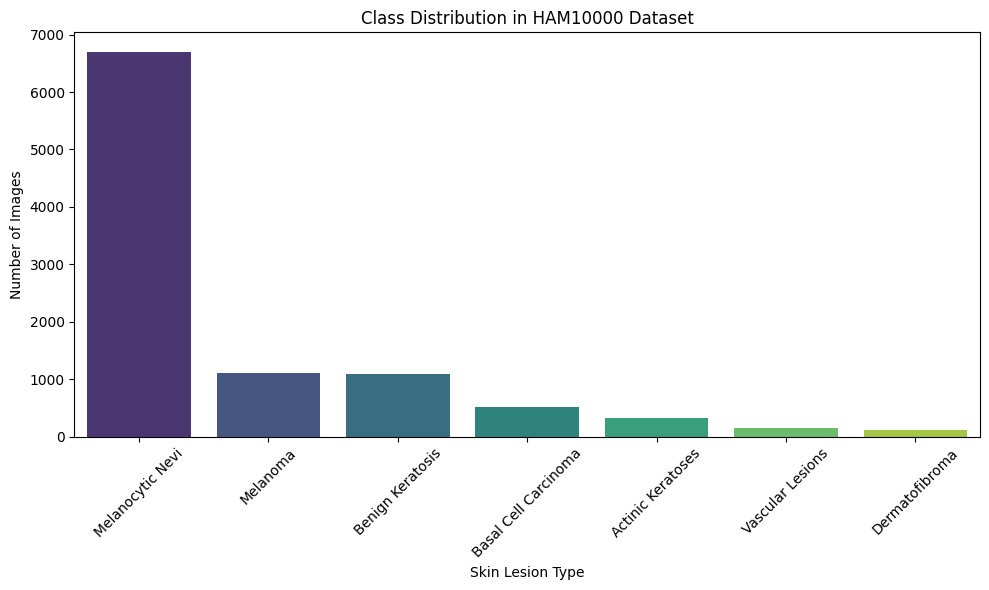

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the metadata CSV file
metadata_path = r'C:\profolders\Collage stuff\Sem 4 project\DL\Datasets\HAM10000\HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)

# Display first few rows to understand the structure
print(metadata.head())

# Class distribution
class_counts = metadata['dx'].value_counts()

# Mapping class codes to full names for better visualization
class_labels = {
    'akiec': 'Actinic Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic Nevi',
    'vasc': 'Vascular Lesions',
    'mel': 'Melanoma'
}

# Map codes to labels
class_counts.index = class_counts.index.map(class_labels)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

plt.title('Class Distribution in HAM10000 Dataset')
plt.xlabel('Skin Lesion Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random

# Paths
image_dirs = [r'C:\profolders\Collage stuff\Sem 4 project\DL\Datasets\HAM10000\HAM10000_images_part_1',
              r'C:\profolders\Collage stuff\Sem 4 project\DL\Datasets\HAM10000\HAM10000_images_part_2']
metadata_path = r'C:\profolders\Collage stuff\Sem 4 project\DL\Datasets\HAM10000\HAM10000_metadata.csv'

# Constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16

# Load metadata
metadata = pd.read_csv(metadata_path)
image_ids = metadata['image_id'].values
labels = metadata['dx'].values  # Skin cancer class labels

# Custom Dataset
class HAM10000Dataset(Dataset):
    def __init__(self, image_ids, labels, image_dirs, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dirs = image_dirs
        self.transform = transform

        # Filter valid images at initialization
        self.valid_data = [(img_id, label) for img_id, label in zip(image_ids, labels) if self.image_exists(img_id)]

    def image_exists(self, image_id):
        return any(os.path.exists(os.path.join(dir, f"{image_id}.jpg")) for dir in self.image_dirs)

    def load_image(self, image_id):
        for dir in self.image_dirs:
            path = os.path.join(dir, f"{image_id}.jpg")
            if os.path.exists(path):
                return Image.open(path).convert("RGB").resize(IMAGE_SIZE)
        return None

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        image_id, label = self.valid_data[idx]
        image = self.load_image(image_id)

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] for GANs
])

# Train-Validation-Test Split (70%-15%-15%)
train_ids, temp_ids, train_labels, temp_labels = train_test_split(image_ids, labels, test_size=0.3, random_state=42)
val_ids, test_ids, val_labels, test_labels = train_test_split(temp_ids, temp_labels, test_size=0.5, random_state=42)

# Create datasets
train_dataset = HAM10000Dataset(train_ids, train_labels, image_dirs, transform=basic_transform)
val_dataset = HAM10000Dataset(val_ids, val_labels, image_dirs, transform=basic_transform)
test_dataset = HAM10000Dataset(test_ids, test_labels, image_dirs, transform=basic_transform)

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print Dataset Sizes
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 7010
Validation samples: 1502
Test samples: 1503


In [ ]:
def dice_coefficient(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    correct = (pred == target).sum().item()
    total = target.size(0)
    return correct / total


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import os

# Hyperparameters
latent_dim = 100
num_classes = 7
image_size = 128
batch_size = 64
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class mapping for labels
class_to_idx = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}

# Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 3 * image_size * image_size), nn.Tanh()
        )
    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)
        input_vector = torch.cat((noise, label_embedding), dim=1)
        return self.model(input_vector).view(-1, 3, image_size, image_size)

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(3 * image_size * image_size + num_classes, 1024), nn.LeakyReLU(0.2),
            nn.Linear(1024, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1), nn.Sigmoid()
        )
    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_embedding = self.label_embedding(labels)
        input_vector = torch.cat((img_flat, label_embedding), dim=1)
        return self.model(input_vector)

# Initialize models and optimizers
generator = Generator(latent_dim, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)
generator.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
discriminator.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Checkpoint function
def save_checkpoint(epoch):
    checkpoint_path = 'gan_checkpoint.pth'
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
    torch.save({'epoch': epoch, 'generator': generator.state_dict(), 'discriminator': discriminator.state_dict()}, checkpoint_path)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    for batch in train_loader:
        real_images = batch[0].to(device)
        labels = torch.tensor([class_to_idx[label] for label in batch[1]], dtype=torch.long).to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise, labels)
        real_loss = criterion(discriminator(real_images, labels), torch.ones(batch_size, 1).to(device))
        fake_loss = criterion(discriminator(fake_images.detach(), labels), torch.zeros(batch_size, 1).to(device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_images, labels), torch.ones(batch_size, 1).to(device))
        g_loss.backward()
        optimizer_G.step()

    save_checkpoint(epoch + 1)
    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

print("Finished Training")

Epoch [1/200] | D Loss: 0.2219 | G Loss: 3.7457
Epoch [2/200] | D Loss: 0.6105 | G Loss: 1.7950
Epoch [3/200] | D Loss: 1.6989 | G Loss: 0.6256
Epoch [4/200] | D Loss: 1.0073 | G Loss: 1.3483
Epoch [5/200] | D Loss: 1.0225 | G Loss: 0.6579
Epoch [6/200] | D Loss: 2.7435 | G Loss: 0.2271
Epoch [7/200] | D Loss: 0.2582 | G Loss: 3.7149
Epoch [8/200] | D Loss: 0.9374 | G Loss: 0.7223
Epoch [9/200] | D Loss: 2.1843 | G Loss: 0.5377
Epoch [10/200] | D Loss: 1.2905 | G Loss: 2.4176
Epoch [11/200] | D Loss: 1.2480 | G Loss: 0.5421
Epoch [12/200] | D Loss: 1.2278 | G Loss: 3.4105
Epoch [13/200] | D Loss: 1.2053 | G Loss: 1.0661
Epoch [14/200] | D Loss: 1.1815 | G Loss: 0.7302
Epoch [15/200] | D Loss: 2.2520 | G Loss: 0.5078
Epoch [16/200] | D Loss: 1.0924 | G Loss: 0.6715
Epoch [17/200] | D Loss: 0.8946 | G Loss: 1.7998
Epoch [18/200] | D Loss: 1.4366 | G Loss: 1.5649
Epoch [19/200] | D Loss: 0.9095 | G Loss: 2.0260
Epoch [20/200] | D Loss: 1.3066 | G Loss: 0.9265
Epoch [21/200] | D Loss: 1.36

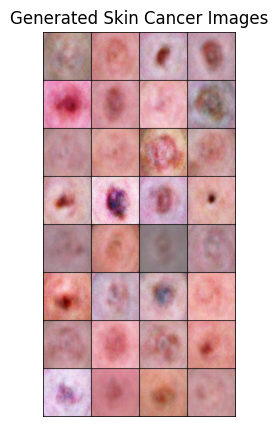

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def generate_and_show_images(generator, num_images=32):
    generator.eval()  # Set generator to evaluation mode
    noise = torch.randn(num_images, latent_dim).to(device)

    # Generate random labels
    random_labels = torch.randint(0, num_classes, (num_images,)).to(device)

    # Generate images
    with torch.no_grad():
        fake_images = generator(noise, random_labels)

    # Denormalize images (optional, depending on your training process)
    fake_images = (fake_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Convert to CPU for visualization
    fake_images = fake_images.cpu()

    # Display images
    plt.figure(figsize=(10, 5))
    plt.axis("off")
    plt.title("Generated Skin Cancer Images")
    plt.imshow(
        np.transpose(vutils.make_grid(fake_images, nrow=4, padding=2, normalize=True), (1, 2, 0))
    )
    plt.show()

# Call function to visualize images
generate_and_show_images(generator)

In [ ]:
import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from pathlib import Path

# Number of images to generate per class
class_counts = {
    'nv': 295,
    'mel': 5887,
    'bkl': 5901,
    'bcc': 6486,
    'akiec': 6673,
    'vasc': 6858,
    'df': 6885
}

output_folder = Path('generated_skin_cancer_images')
output_folder.mkdir(parents=True, exist_ok=True)

def generate_class_images(generator, class_name, num_images):
    generator.eval()
    noise = torch.randn(num_images, latent_dim).to(device)
    labels = torch.full((num_images,), class_to_idx[class_name], dtype=torch.long).to(device)

    with torch.no_grad():
        fake_images = generator(noise, labels)
    
    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    class_folder = output_folder / class_name
    class_folder.mkdir(parents=True, exist_ok=True)

    for i, img in enumerate(fake_images):
        vutils.save_image(img, class_folder / f"{class_name}_{i+1}.jpg")

    print(f"Generated {num_images} images for class {class_name}.")

for class_name, count in class_counts.items():
    generate_class_images(generator, class_name, count)

print("All images generated successfully.")

Generated 295 images for class nv.
Generated 5887 images for class mel.
Generated 5901 images for class bkl.
Generated 6486 images for class bcc.
Generated 6673 images for class akiec.
Generated 6858 images for class vasc.
Generated 6885 images for class df.
All images generated successfully.


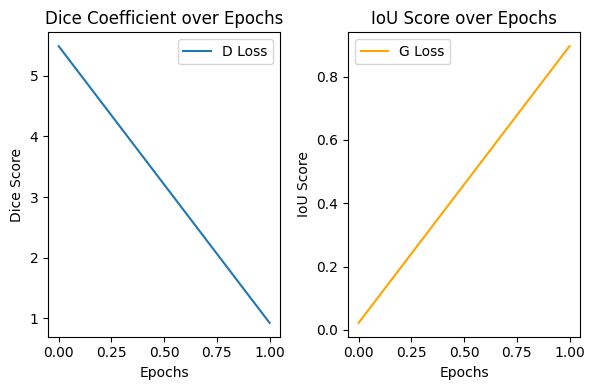

In [41]:
import matplotlib.pyplot as plt

# Assuming you stored metrics in lists
epochs_range = range(2)
plt.figure(figsize=(9, 4))

# Dice Coefficient
plt.subplot(1, 3, 1)
plt.plot(epochs_range, d_losses, label='D Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Dice Coefficient over Epochs')
plt.legend()

# IoU Score
plt.subplot(1, 3, 2)
plt.plot(epochs_range, g_losses, label='G Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('IoU Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

##Save

In [ ]:
# Save the entire model (architecture + weights)
torch.save(model, 'GAN_final.pth')

In [ ]:
# Load the entire saved model
import torch
model = torch.load('GAN_final.pth', weights_only=False)
model.eval()

AttentionUNet(
  (conv1): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), strid

#DL class 13/02/2025

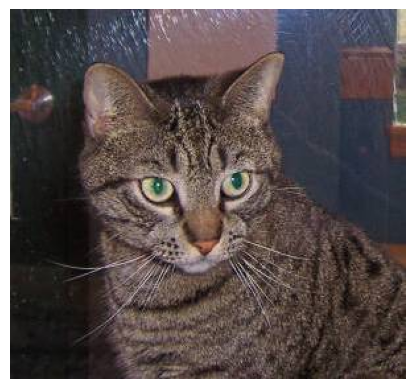

Extracted Features Shape: torch.Size([3, 2048])
Proposal 1:
  Region: [50, 30, 200, 180]
  Predicted Class: 0 (Probabilities: [0.37902963 0.3439898  0.2769805 ])
  Predicted BBox Adjustments: [ 0.25981587 -0.04684008  0.1360797   0.06938279]
Proposal 2:
  Region: [150, 100, 300, 250]
  Predicted Class: 0 (Probabilities: [0.42665917 0.32833016 0.24501067])
  Predicted BBox Adjustments: [ 0.11184458  0.13327712  0.1522057  -0.0534558 ]
Proposal 3:
  Region: [200, 50, 350, 200]
  Predicted Class: 0 (Probabilities: [0.37316945 0.34715602 0.27967456])
  Predicted BBox Adjustments: [ 0.17234862 -0.15457045  0.28263262  0.13302252]


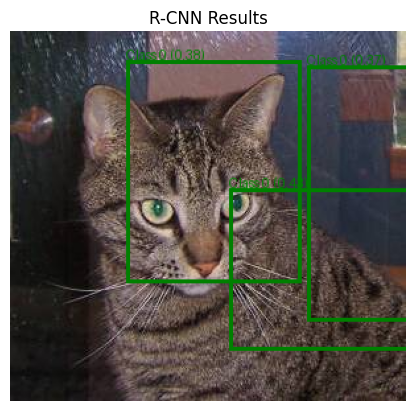

In [45]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from PIL import Image, ImageDraw
# Load the image
image_path = '/content/cat.1.jpg'  # Replace with the path to your image
image = Image.open(image_path).convert("RGB")

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

# Dummy region proposals (manually defined for simplicity)
# Format: [x1, y1, x2, y2]
region_proposals = [
    [50, 30, 200, 180],  # Region 1
    [150, 100, 300, 250],  # Region 2
    [200, 50, 350, 200],  # Region 3
]

# Pre-trained ResNet50 as a feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

    def forward(self, x):
        return self.feature_extractor(x).squeeze()

# Instantiate the feature extractor
feature_extractor = FeatureExtractor()
feature_extractor.eval()


# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extract features for each region proposal
features = []
for proposal in region_proposals:
    x1, y1, x2, y2 = proposal
    cropped_region = image.crop((x1, y1, x2, y2))  # Crop the proposal region
    input_tensor = transform(cropped_region).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        feature = feature_extractor(input_tensor)
    features.append(feature)

# Stack features
features = torch.stack(features)
print("Extracted Features Shape:", features.shape)


# Classification and bounding box regression heads
class RCNNHead(nn.Module):
    def __init__(self, num_classes):
        super(RCNNHead, self).__init__()
        self.fc_class = nn.Linear(2048, num_classes)  # For classification
        self.fc_bbox = nn.Linear(2048, 4)  # For bounding box regression

    def forward(self, x):
        class_logits = self.fc_class(x)
        bbox_deltas = self.fc_bbox(x)
        return class_logits, bbox_deltas

# Instantiate the R-CNN head
rcnn_head = RCNNHead(num_classes=3)  # Example: 3 classes (e.g., dog, cat, background)
rcnn_head.eval()



# Dummy labels for the proposals
labels = torch.tensor([1, 2, 0])  # Example: 1 = dog, 2 = cat, 0 = background

# Predict classes and bounding boxes
with torch.no_grad():
    class_logits, bbox_deltas = rcnn_head(features)

# Convert logits to probabilities
class_probs = torch.softmax(class_logits, dim=1)

# Print results
for i, proposal in enumerate(region_proposals):
    print(f"Proposal {i+1}:")
    print(f"  Region: {proposal}")
    print(f"  Predicted Class: {torch.argmax(class_probs[i]).item()} (Probabilities: {class_probs[i].numpy()})")
    print(f"  Predicted BBox Adjustments: {bbox_deltas[i].numpy()}")


# Adjust bounding boxes
adjusted_bboxes = []
for i, proposal in enumerate(region_proposals):
    x1, y1, x2, y2 = proposal
    dx, dy, dw, dh = bbox_deltas[i].numpy()
    adjusted_bboxes.append([
        int(x1 + dx * (x2 - x1)),
        int(y1 + dy * (y2 - y1)),
        int(x2 + dw * (x2 - x1)),
        int(y2 + dh * (y2 - y1)),
    ])

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for i, bbox in enumerate(adjusted_bboxes):
    x1, y1, x2, y2 = bbox
    label = torch.argmax(class_probs[i]).item()
    prob = class_probs[i][label].item()
    color = "red" if label == 1 else "blue" if label == 2 else "green"  # Class-dependent colors
    draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
    draw.text((x1, y1 - 10), f"Class {label} ({prob:.2f})", fill=color)

# Display the image
plt.imshow(image)
plt.axis("off")
plt.title("R-CNN Results")
plt.show()

In [48]:
# -- coding: utf-8 --
"""
Created on Thu Feb 13 10:33:44 2025

@author: mithun
"""


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import numpy as np


class MockDataset(Dataset):
    def __init__(self, num_samples=100):
        super().__init__()
        self.num_samples = num_samples
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Mock data: Random images, proposals, and labels
        self.images = [torch.randint(0, 256, (3, 256, 256), dtype=torch.uint8) for _ in range(num_samples)]
        self.proposals = [[[
            [random.randint(0, 200), random.randint(0, 200), random.randint(100, 256), random.randint(100, 256)]
            for _ in range(random.randint(1, 5))
        ]] for _ in range(num_samples)]
        self.labels = [[random.randint(0, 2) for _ in range(len(props))] for props in self.proposals]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = self.images[idx]
        proposals = self.proposals[idx]
        labels = self.labels[idx]

        # Convert image to PIL for transformations
        image_pil = transforms.ToPILImage()(image)
        image_tensor = self.transform(image_pil)
        return image_tensor, proposals, labels


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

    def forward(self, x):
        return self.feature_extractor(x).squeeze()


class RCNNHead(nn.Module):
    def __init__(self, num_classes):
        super(RCNNHead, self).__init__()
        self.fc_class = nn.Linear(2048, num_classes)
        self.fc_bbox = nn.Linear(2048, 4)

    def forward(self, x):
        class_logits = self.fc_class(x)
        bbox_deltas = self.fc_bbox(x)
        return class_logits, bbox_deltas


class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.rcnn_head = RCNNHead(num_classes)

    def forward(self, image, proposals):
        outputs = []
        for proposal in proposals:
            x1, y1, x2, y2 = proposal
            if x1 < x2 and y1 < y2:
                cropped = image[:, y1:y2, x1:x2]
                resized = nn.functional.interpolate(cropped.unsqueeze(0), size=(224, 224), mode='bilinear')
                features = self.feature_extractor(resized)
                logits, bbox_deltas = self.rcnn_head(features)
                outputs.append((logits, bbox_deltas))
            else:
                cropped = image[:, 10:200, 10:200]  # Default crop
                resized = nn.functional.interpolate(cropped.unsqueeze(0), size=(224, 224), mode='bilinear')
                features = self.feature_extractor(resized)
                logits, bbox_deltas = self.rcnn_head(features)
                outputs.append((logits, bbox_deltas))

        return outputs


# Initialize dataset and dataloader
dataset = MockDataset(num_samples=100)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize the model, loss, and optimizer
model = RCNN(num_classes=3)
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for images, proposals_list, labels_list in dataloader:
        optimizer.zero_grad()
        losses = []

        for image, proposals, labels in zip(images, proposals_list, labels_list):

            outputs = model(image, proposals)
            for output, label, proposal in zip(outputs, labels, proposals):
                logits, bbox_deltas = output
                # class_loss = criterion_class(logits, torch.tensor([label]))
                bbox_loss = criterion_bbox(bbox_deltas, torch.tensor(proposal, dtype=torch.float32))
                # losses.append(class_loss + bbox_loss)
                losses.append( bbox_loss)

        batch_loss = sum(losses) / len(losses)
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

def visualize_results(image, proposals, labels, adjusted_bboxes):
    image_pil = transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(image_pil)
    for i, bbox in enumerate(adjusted_bboxes):
        x1, y1, x2, y2 = bbox
        label = "LABEL"
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 10), f"Class {label}", fill="red")
    plt.imshow(image_pil)
    plt.axis("off")
    plt.show()


image, proposals, labels = dataset[0]
outputs = model(image, proposals[0])
adjusted_bboxes = [output[1].detach().numpy().tolist() for output in outputs]
visualize_results(image, proposals, labels, adjusted_bboxes)

Epoch 1, Loss: 132.83224380493164


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 142MB/s]


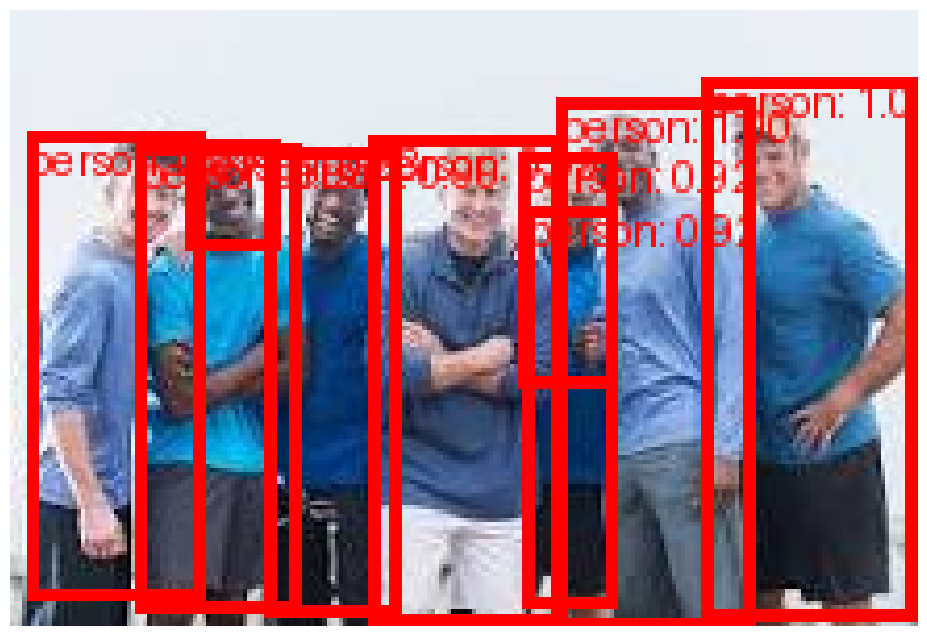

In [49]:
# -- coding: utf-8 --
"""
Created on Sun Jan 19 10:56:55 2025

@author: mithun
"""

import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define a function to visualize detections
def visualize_detections(image, boxes, labels, scores, threshold=0.5):
    """
    Draw bounding boxes on the image for detections with a confidence score above the threshold.
    """
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            draw.rectangle(box.tolist(), outline="red", width=3)
            draw.text((box[0], box[1]), f"{label}: {score:.2f}", fill="red")


# Load an image
image_path = "/content/dude.jpeg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
input_tensor = transform(image).unsqueeze(0)

# Perform object detection
with torch.no_grad():
    detections = model(input_tensor)[0]


# Extract detections
boxes = detections['boxes']
labels = detections['labels']
scores = detections['scores']

# Map label indices to class names (COCO dataset)
COCO_CLASSES = [
    '_background_', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

# Convert label indices to class names
labels_names = [COCO_CLASSES[label] for label in labels]

# Visualize detections
image_with_boxes = image.copy()
visualize_detections(image_with_boxes, boxes, labels_names, scores)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

plt.imsave('image_with_boxes.png',image_with_boxes)